# Accelerated cross-validation for multinomial logistic regression
Demonstration of approximate cross-validation in multinomial logistic regression with the l1 regularization. 

## Sample execution environment
* OS: macOS 10.12.6
* Processor: 2.5 GHz Intel Core i7
* RAM: 16 GB 2133 MHz LPDDR3

## Import libraries

In [1]:
%matplotlib notebook
import warnings

import numpy as np
import matplotlib.pyplot as plt

# from IPython.html.widgets import FloatProgress
from ipywidgets import FloatProgress
from IPython.display import display

# accelerated cross validation module
import accelerated_cv_on_mlr as acv

# glmnet for logistic regression and conventional 
import glmnet_python
from glmnet import glmnet
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef

# set seed
np.random.seed(0)

## Making dummy data 
* dummy training data and list of the $\lambda$s are made

In [2]:
%%time
alpha = 2  # Feature-to-data ratio
N = 800  # Feature vector dimensionality
Np = 4  # Number of classes
rho0 = 0.5  #  Feature-vector density
sigmaN2 = 0.01  # Noise strength
M = np.ceil(alpha * N).astype(np.int64)  # Data dimensionality
K = np.ceil(rho0 * N).astype(np.int64)  # Nonzero-components number
sigmaW2 = 1.0 / rho0  # Approximately set feature-vector norm to sqrt(N)

# True fertures
w0 = np.zeros((N, Np))
for ip in range(Np):
    IND = np.random.permutation(N)
    S_A = np.sort(IND[0:K])
    
    # True features of each class
    w0[S_A, ip] = np.sqrt(sigmaW2) * np.random.normal(loc=0, scale=1, size=K)  

# Observed fertures and classes
X = np.zeros((M, N))  # Observed feature vector
Y = np.random.randint(low=0, high=Np, size=(M, 1))  # Observed classes
Ycode = np.zeros((M, Np))  # Binary representation of observed classes
for index in range(M):
    # True class of mu-th observation 
    class_index = Y[index]

    # Binary representation of class
    Ycode[index, class_index] = 1

    # Observation=True feature+Gaussian noise
    true_feature = w0[:, class_index] / np.sqrt(N)
    noise = np.sqrt(sigmaN2) * np.random.normal(0, 1, (N, 1))
    X[index, :] = (true_feature + noise).reshape(N, )

X_std = acv.utils.standardize_matrix.standardize_matrix(X)

r_exp = 0.06
lambdaV = np.power(10.0, -r_exp * np.arange(0, 101))

CPU times: user 73.8 ms, sys: 9.4 ms, total: 83.2 ms
Wall time: 83.8 ms


## Fitting model via glmnet

In [3]:
%%time
fit = glmnet(x=X_std.copy().astype(np.float64),
             y=Y.copy().astype(np.float64),
             family='multinomial',
             intr=False,
             lambdau=lambdaV,
             thresh=1e-8,
             maxit=1e7,
             standardize=False
             )

CPU times: user 5.21 s, sys: 35.5 ms, total: 5.25 s
Wall time: 5.29 s


## $k$-fold CV via glmnet

### $10$-fold

In [4]:
%%time
warnings.filterwarnings('ignore')
cvfit_10fold = cvglmnet(x=X_std.astype(np.float64).copy(),
                        y=Y.astype(np.float64).copy(),
                        family='multinomial',
                        mtype="ungrouped",
                        lambdau=fit["lambdau"][:89],
                        intr=False,
                        standardize=False,
                        thresh=1e-8,
                        maxit=1e7,
                        parallel=True,
                        nfolds=10)
warnings.filterwarnings('default')

[status]	Parallel glmnet cv with 4 cores


CPU times: user 5.58 s, sys: 119 ms, total: 5.7 s
Wall time: 26.6 s


### $100$-fold
* this may take long time

In [12]:
%%time
## WARNING: THIS MAY TAKE LONG TIME
cvfit_100fold = None
# warnings.filterwarnings('ignore')
# cvfit_100fold = cvglmnet(x=X_std.astype(np.float64).copy(),
#                          y=Y.astype(np.float64).copy(),
#                          family='multinomial',
#                          mtype="ungrouped",
#                          lambdau=fit["lambdau"][:89],
#                          intr=False,
#                          standardize=False,
#                          thresh=1e-8,
#                          maxit=1e7,
#                          parallel=True,
#                          nfolds=100)
# warnings.filterwarnings('default')

[status]	Parallel glmnet cv with 4 cores


CPU times: user 7.33 s, sys: 420 ms, total: 7.75 s
Wall time: 4min 7s


### $1000$-fold
* this may take extremely long time

In [6]:
%%time
## WARNING: THIS MAY TAKE EXTREMELY LONG TIME
cvfit_1000fold = None
# warnings.filterwarnings('ignore')
# cvfit_1000fold = cvglmnet(x=X_std.astype(np.float64).copy(),
#                          y=Y.astype(np.float64).copy(),
#                          family='multinomial',
#                          mtype="ungrouped",
#                          lambdau=fit["lambdau"][:89],
#                          intr=False,
#                          standardize=False,
#                          thresh=1e-8,
#                          maxit=1e7,
#                          parallel=True,
#                          nfolds=1000)
# warnings.filterwarnings('default')

[status]	Parallel glmnet cv with 4 cores


CPU times: user 25.8 s, sys: 3.2 s, total: 29 s
Wall time: 39min 40s


## Approximate Leave-One-Out-CV via ACV

In [7]:
# weight vector
wV = np.zeros((N, Np, fit["lambdau"].shape[0]))
for ip in range(Np):
    for ilam in range(fit["lambdau"].shape[0]):
        wV[:, ip, ilam] = fit["beta"][ip][:, ilam]

In [8]:
%%time
fp = FloatProgress(min=0, max=fit["lambdau"].shape[0] - 1, description="calculating...")
display(fp)

LOOE_list = []
ERR_list = []
for ilam in range(fit["lambdau"].shape[0]):
    fp.value = ilam
    LOOE, ERR = acv.acv_mlr(wV[:, :, ilam].transpose(), X_std, Ycode, Np)
    LOOE_list.append(LOOE)
    ERR_list.append(ERR)

A Jupyter Widget

CPU times: user 1min 22s, sys: 5.61 s, total: 1min 28s
Wall time: 37 s


## Approximate Leave-One-Out-CV via SAACV

In [9]:
%%time
fp = FloatProgress(min=0, max=fit["lambdau"].shape[0] - 1, description="calculating...")
display(fp)

LOOE_SA_list = []
ERR_SA_list = []
for ilam in range(fit["lambdau"].shape[0]):
    fp.value = ilam
    LOOE, ERR = acv.saacv_mlr(wV[:, :, ilam].transpose(), X_std, Ycode, Np)
    LOOE_SA_list.append(LOOE)
    ERR_SA_list.append(ERR)

A Jupyter Widget

CPU times: user 25.6 s, sys: 869 ms, total: 26.4 s
Wall time: 14 s


## Comparing result

<IPython.core.display.Javascript object>


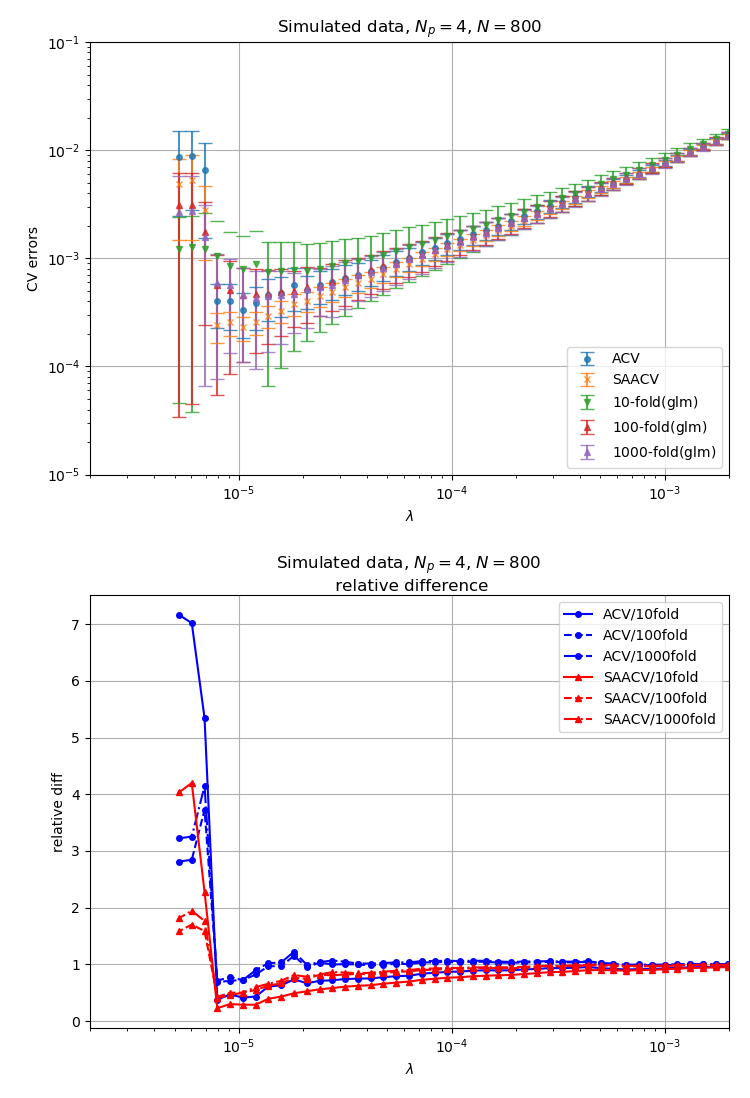

In [13]:
########### 
fig = plt.figure(figsize=(6.5,10))
ax = fig.add_subplot(211)

x = cvfit_10fold["lambdau"]

y_acv = LOOE_list[:-1]
err_acv = ERR_list[:-1]

y_saacv = LOOE_SA_list[:-1]
err_saacv = ERR_SA_list[:-1]

y_glm_10fold = cvfit_10fold["cvm"] / 2.0
err_glm_10fold = cvfit_10fold["cvsd"] / np.sqrt(2.0)

ax.errorbar(x, y_acv, yerr=err_acv, fmt="o",
            capsize=5, ms=4, label="ACV", alpha=0.8)
ax.errorbar(x, y_saacv, yerr=err_saacv, fmt="x",
            capsize=5, ms=4, label="SAACV", alpha=0.8)
ax.errorbar(x, y_glm_10fold, yerr=err_glm_10fold, fmt="v",
            capsize=5, ms=4, label="$10$-fold(glm)", alpha=0.8)
if cvfit_100fold is not None:
    y_glm_100fold = cvfit_100fold["cvm"] / 2.0
    err_glm_100fold = cvfit_100fold["cvsd"] / np.sqrt(2.0)
    ax.errorbar(x, y_glm_100fold, yerr=err_glm_100fold, fmt="^",
                capsize=5, ms=4, label="$100$-fold(glm)", alpha=0.8)

if cvfit_1000fold is not None:
    y_glm_1000fold = cvfit_1000fold["cvm"] / 2.0
    err_glm_1000fold = cvfit_1000fold["cvsd"] / np.sqrt(2.0)
    ax.errorbar(x, y_glm_1000fold, yerr=err_glm_100fold, fmt="^",
                capsize=5, ms=4, label="$1000$-fold(glm)", alpha=0.8)

ax.grid()
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e-6 * 2, 1e-3*2])
ax.set_ylim([1e-5, 1e-1])

ax.set_title("Simulated data, $N_p=${0}, $N=${1}".format(Np, N))
ax.set_ylabel("CV errors")

ax.set_xlabel("$λ$")

###########

ax = fig.add_subplot(212)

x = cvfit_10fold["lambdau"]

y_acv = LOOE_list[:-1]
y_saacv = LOOE_SA_list[:-1]
y_glm_10fold = cvfit_10fold["cvm"] / 2.0
if cvfit_100fold is not None:
    y_glm_100fold = cvfit_100fold["cvm"] / 2.0
if cvfit_1000fold is not None:
    y_glm_1000fold = cvfit_1000fold["cvm"] / 2.0

ax.plot(x, y_acv/y_glm_10fold, "-o",label="ACV/10fold", c="b", ms=4)
if cvfit_100fold is not None:
    ax.plot(x, y_acv/y_glm_100fold, "--o", label="ACV/100fold", c="b", ms=4)
if cvfit_1000fold is not None:
    ax.plot(x, y_acv/y_glm_1000fold, "-.o", label="ACV/1000fold", c="b", ms=4)

ax.plot(x, y_saacv/y_glm_10fold, "-^",label="SAACV/10fold", c="r", ms=4)
if cvfit_100fold is not None:
    ax.plot(x, y_saacv/y_glm_100fold, "--^", label="SAACV/100fold", c="r", ms=4)
if cvfit_1000fold is not None:
    ax.plot(x, y_saacv/y_glm_1000fold, "-.^", label="SAACV/1000fold", c="r", ms=4)

ax.grid()
ax.legend()
ax.set_xscale("log")
ax.set_xlim([1e-6 * 2, 1e-3*2])

ax.set_title("Simulated data, $N_p=${0}, $N=${1} \n relative difference".format(Np, N))
ax.set_ylabel("relative diff")

ax.set_xlabel("$λ$")

fig.tight_layout()